In [1]:
import os.path
import numpy as np
import h5py
import tensorflow as tf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl
from sklearn.model_selection import train_test_split

In [2]:
root =r"C:\Users\nampo\Downloads"

in_file = h5py.File(os.path.join(root,"ascad-variable.h5"), "r")
print(in_file.keys())

# Load profiling traces
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.float64)
Y_profiling = np.array(in_file['Profiling_traces/labels'], dtype = np.uint8)

# Load attacking traces
X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.float64)
Y_attack = np.array(in_file['Attack_traces/labels'], dtype = np.uint8)

<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>


In [3]:
print(X_profiling.shape)
print(X_attack)
print(Y_profiling.shape)
print(Y_attack)
print(min(Y_profiling), max(Y_profiling))
print(np.min(X_profiling), np.max(X_profiling))

(200000, 1400)
[[-20. -22. -27. ... -86. -85. -86.]
 [-20. -24. -28. ... -85. -85. -84.]
 [-19. -25. -29. ... -85. -86. -85.]
 ...
 [-21. -23. -28. ... -85. -87. -85.]
 [-21. -24. -29. ... -86. -84. -85.]
 [-21. -21. -26. ... -85. -85. -85.]]
(200000,)
[145 220   4 ...  49 208 251]
0 255
-116.0 100.0


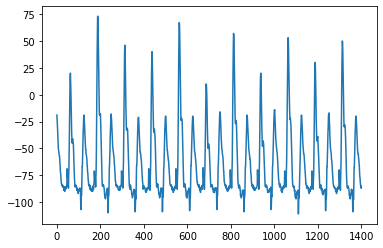

In [4]:
plt.plot(X_profiling[0,:])

In [10]:
#Function to generate triplet inputs
def generate_triplet(list_X, list_y,X,y):
    triplets = np.zeros((1,4200))
    labels = []
    for i in range(X.shape[0]):
        index_pos = np.random.choice(np.where(list_y == y[i])[0])
        index_neg = np.random.choice(np.where(list_y != y[i])[0])
        result = np.concatenate((X[i,:],list_X[index_pos,:]), axis = -1)
        result = np.concatenate((result, list_X[index_neg,:]), axis = -1)
        triplets = np.concatenate((triplets, result[np.newaxis,:]), axis = 0)
        assert y[i] == list_y[index_pos] and y[i] != list_y[index_neg]
        labels.append(np.array([y[i], list_y[index_pos], list_y[index_neg]]))
    triplets = np.delete(triplets, 0,axis = 0)
    return triplets, labels

In [11]:
#Function to normalize dataset
def normalize(X_train, mean = None, std = None):
    if mean is None or std is None:
        mean = np.mean(X_train)
        std = np.std(X_train)
    X_train =(X_train - mean)/std
    return X_train, mean, std

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_profiling, Y_profiling, test_size=0.3, random_state=42, shuffle=True)

X_train, mean, std = normalize(X_train)
X_val, mean, std = normalize(X_val, mean, std)

batch_size = 512

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

140000
140000
[-21. -25. -28. ... -85. -85. -84.]


In [13]:
#After normalization
print(X_train[0])
print(np.min(X_train), np.max(X_train))
print(len(train_dataset))

[ 1.25609351  1.13812754  1.04965306 ... -0.63136202 -0.63136202
 -0.60187053]
-1.5455982909779373 4.824564109683627
274


In [14]:
#Triplet model
def Triplet(input_shape, embedding_size):
    model = tk.Sequential()
    model.add(tkl.Conv1D(input_shape=input_shape,filters=64,kernel_size=15,padding="same"))
    model.add(tkl. BatchNormalization())
    model.add(tkl.AveragePooling1D(pool_size=15,strides=15))
    model.add(tkl.Conv1D(filters=128, kernel_size=3, padding="same"))
    model.add(tkl. BatchNormalization())
    model.add(tkl.AveragePooling1D(pool_size=2,strides=2))
    model.add(tkl.Flatten(name='Flatten'))
    model.add(tkl.Dense(embedding_size))
    return model

model = Triplet(input_shape = (1400,1), embedding_size = 32)
optimizer = tk.optimizers.Adam(learning_rate = 0.0001, weight_decay = 0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1400, 64)          1024      
                                                                 
 batch_normalization (BatchN  (None, 1400, 64)         256       
 ormalization)                                                   
                                                                 
 average_pooling1d (AverageP  (None, 93, 64)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 93, 128)          512       
 hNormalization)                                                 
                                                        

In [15]:

def loss_euclidian(feature):
    result = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(feature),axis = 1))
    result = tf.math.reduce_sum(result)
    return result

In [16]:
def loss(feature, labels, num_classes, alpha_value):
    #Hybrid distance explained in the paper "Best of two worlds: deep learning assisted SCA"
    feature_distance = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(feature),axis = 1))
    label_distance = tf.math.pow(alpha_value,tf.math.sqrt(tf.math.reduce_sum(tf.math.square(labels),axis = 1))/num_classes)
    result = tf.squeeze(feature_distance)/tf.cast(label_distance, tf.float64)
    result = tf.math.reduce_sum(result)
    return result

In [18]:
def train(model,X_profiling, Y_profiling, train_dataset, val_dataset, optimizer, epochs = 5, euclidian = True):
    list_train_loss = []
    num_classes = 256
    alpha_value = 0.2
    margin = 0.3
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        for step,(x_batch,labels) in enumerate(train_dataset):
            triplets, triple_labels = generate_triplet(X_train, y_train, x_batch,labels)
            triplets = triplets[:,:,np.newaxis]
            with tf.GradientTape() as tape:
                anchor = model(triplets[:,:1400,:], training=True)
                pos = model(triplets[:,1400:2800,:], training=True)
                neg = model(triplets[:,2800:,:], training=True)
                if euclidian: #If we use euclidean loss
                    loss_value = loss_euclidian(anchor - pos) - loss_euclidian(anchor - neg)
                else: #If we use hybrid loss
                    loss_value = loss(triplets[:,:1400,:] - triplets[:,1400:2800,:],anchor - pos, num_classes, alpha_value) 
                    - loss(triplets[:,:1400,:] - triplets[:,2800:,:],anchor - neg, num_classes, alpha_value)
                loss_value = tf.math.maximum(loss_value + margin, 0.0)
            list_train_loss.append(loss_value.numpy())
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return list_train_loss

In [19]:
list_train_loss = train(model,X_profiling, Y_profiling, train_dataset, val_dataset, optimizer, epochs = 5)


Start of epoch 0
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.8892639, shape=(), dtype=float32)
loss tf.Tensor(6.8817263, shape=(), dtype=float32)
loss tf.Tensor(1.7553833, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(4.030225, shape=(), dtype=float32)
loss tf.Tensor(8.254712, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(11.586011, shape=(), dtype=float32)
loss tf.Tensor(7.8393373, shape=(), dtype=float32)
loss tf.Tensor(0.39274293, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.7134216, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(8.139234, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(12.508985, shape=(), dtype=float32)
loss tf.Tensor(4.2

loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.675885, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.2352722, shape=(), dtype=float32)
loss tf.Tensor(0.3348511, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(5.0322237, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.6736724, shape=(), dtype=float32)
loss tf.Tensor(6.619092, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.7557495, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(6.0861483, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.T

loss tf.Tensor(5.284528, shape=(), dtype=float32)
loss tf.Tensor(0.76762086, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(3.8806884, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(4.4420595, shape=(), dtype=float32)
loss tf.Tensor(8.115811, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.3989532, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.731427, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.686734, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.6851623, shape=(), dtype=float32)
loss tf.Tensor(0.72486573, shape=(), dtype=float3

loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.81239, shape=(), dtype=float32)
loss tf.Tensor(0.87878114, shape=(), dtype=float32)
loss tf.Tensor(2.4298522, shape=(), dtype=float32)
loss tf.Tensor(3.471463, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.8109558, shape=(), dtype=float32)
loss tf.Tensor(4.638364, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.24300843, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(9.228757, shape=(), dtype=float32)
loss tf.Tensor(1.3472717, shape=(), dtype=float32)
loss tf.Tensor(6.4895296, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.8478515, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=f

loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.353009, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(7.907422, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.31406862, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(4.9384584, shape=(), dtype=float32)
loss tf.Tensor(3.8200958, shape=(), dtype=float32)
loss tf.Tensor(2.425, shape=(), dtype=float32)
loss tf.Tensor(3.2769134, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.2222412, shape=(), dtype=float32)
loss tf.Tensor(11.771085, shape=(), dtype=float32)
loss tf.Tensor(1.5310638, shape=(), dtype=float32)


loss tf.Tensor(4.9624605, shape=(), dtype=float32)
loss tf.Tensor(3.3337371, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.3072326, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(3.8464324, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.7102478, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.135327, shape=(), dtype=float32)
loss tf.Tensor(1.2236145, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.0439727, shape=(), dtype=float32)
loss tf.Tensor(2.050122, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(2.4480712, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float3

loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.9614685, shape=(), dtype=float32)
loss tf.Tensor(3.3277404, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(5.28201, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.9029053, shape=(), dtype=float32)
loss tf.Tensor(0.18635255, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(7.9213686, shape=(), dtype=float32)
loss tf.Tensor(2.5152862, shape=(), dtype=float32)
loss tf.Tensor(3.6581542, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(1.8110015, shape=(), dtype=float32)
loss tf.Tensor(3.5627716, shape=(), dtype=float32)
loss tf.Tensor(3.6439178, shape=(), dtype

loss tf.Tensor(0.0047424436, shape=(), dtype=float32)
loss tf.Tensor(0.5190399, shape=(), dtype=float32)
loss tf.Tensor(5.1800203, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(4.505719, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(4.1403933, shape=(), dtype=float32)
loss tf.Tensor(2.279538, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.0, shape=(), dtype=float32)
loss tf.Tensor(0.77470094, shape=(), dtype=float32)
loss tf.Ten

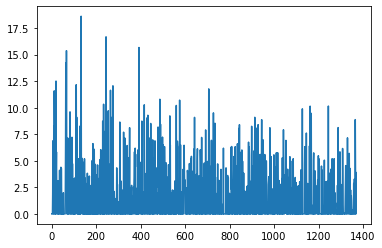

In [20]:
plt.plot(list_train_loss)